[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)

# Unsupervised learning with Autoencoder

We first play with MNIST dataset and pieces of code seen during the course.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

%matplotlib inline

## Loading MNIST

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


In [3]:
# to be modified if not on colab
root_dir ='/Users/ilpreterosso/GitHub/datasets/NN101-dateflower/'
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=True, download=True, transform=transforms.ToTensor()),
    batch_size=256, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

## Helper Functions

In [4]:
def to_img(x):
    x = x.cpu().data.numpy()
    x = 0.5 * (x + 1)
    x = np.clip(x, 0, 1)
    x = x.reshape([-1, 28, 28])
    return x

def plot_reconstructions(model: nn.Module):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    The middle row is the encoded vector.
    The encoder is called by model.encoder
    The decoder is called by model.decoder
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    data = data.view([-1, 784])
    data.requires_grad = False
    data = data.to(device)
    true_imgs = data
    encoded_imgs = model.encoder(data)
    decoded_imgs = model.decoder(encoded_imgs)
    
    true_imgs = to_img(true_imgs)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

## Simple Auto-Encoder

We'll start with the simplest autoencoder: a single, fully-connected layer as the encoder and decoder.

In [5]:
# simpliest auto-encoder
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_dim)

    def forward(self, x):
        encoded = F.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded

In [6]:
input_dim = 784
encoding_dim = 64

model = AutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

Why did we take 784 as input dimension?

To find the learning rate, see the documentation for [Adam optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).

In [7]:
def train_model(model,loss_fn,data_loader=None,epochs=1,optimizer=None,verbose=False):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view([-1, 784]).to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            if (verbose):
                if batch_idx % 100 == 0:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(data_loader.dataset),
                        100. * batch_idx / len(data_loader), loss.data.item()))
        if (~verbose):
            print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch, loss))

In [8]:
train_model(model, loss_fn, data_loader=train_loader, epochs=10, optimizer=optimizer)

Train Epoch: 0	Loss: 0.029987
Train Epoch: 1	Loss: 0.022586
Train Epoch: 2	Loss: 0.017121
Train Epoch: 3	Loss: 0.018039
Train Epoch: 4	Loss: 0.016828
Train Epoch: 5	Loss: 0.016314
Train Epoch: 6	Loss: 0.016180
Train Epoch: 7	Loss: 0.015681
Train Epoch: 8	Loss: 0.015253
Train Epoch: 9	Loss: 0.016442


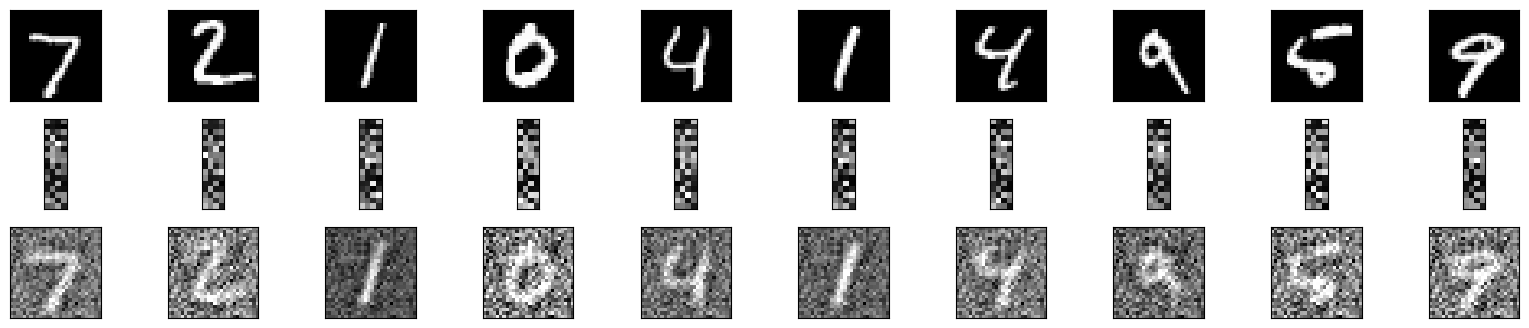

In [9]:
plot_reconstructions(model)

## 1. Exercise: Stacked Autoencoder

Now you will code an autoencoder where both the encoder and the decoder are multilayer perceptron (MLP). You can take for the encoder a first hidden layer with dimension 128, a second one with dimension 64 and then the code of dimension 32. For the decoder, you can take the same sequence of dimensions in reverse order.

In [10]:
class DeepAutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DeepAutoEncoder, self).__init__()
        #
        # your code here
        #
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(), 
            nn.Linear(64, encoding_dim), 
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
        
        
        
    def forward(self, x):
        #
        # your code here
        #
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

In [11]:
input_dim = 784
encoding_dim = 32

model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

In [12]:
train_model(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer)

Train Epoch: 0	Loss: 0.034170
Train Epoch: 1	Loss: 0.025838
Train Epoch: 2	Loss: 0.022935
Train Epoch: 3	Loss: 0.021415
Train Epoch: 4	Loss: 0.018980
Train Epoch: 5	Loss: 0.018277
Train Epoch: 6	Loss: 0.019010
Train Epoch: 7	Loss: 0.016325
Train Epoch: 8	Loss: 0.018287
Train Epoch: 9	Loss: 0.017487


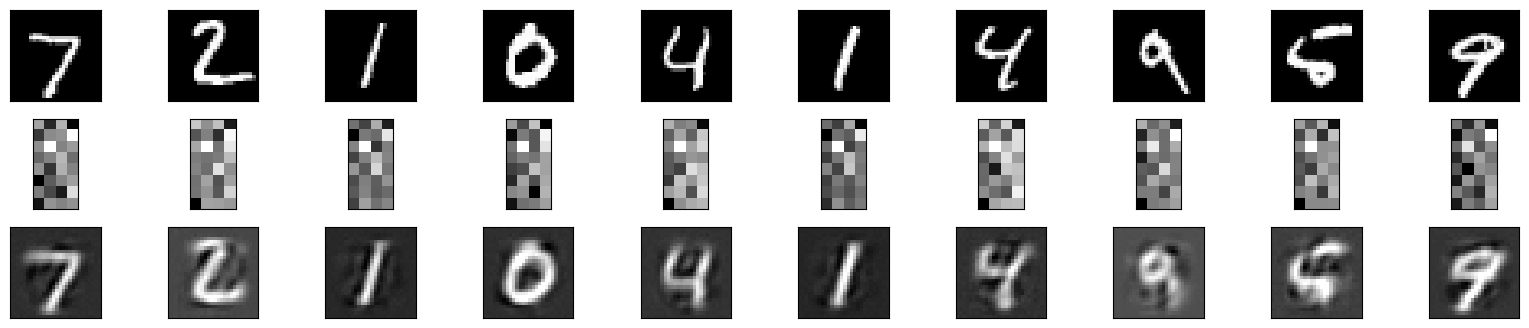

In [13]:
plot_reconstructions(model)

Replace the `MSELoss` with a `BCEWithLogitsLoss` for each pixel. Note the unusual use of `BCEWithLogitsLoss`! You can have a look at the definition of [Cross Entropy](https://en.wikipedia.org/wiki/Cross_entropy).

In [14]:
model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn =torch.nn.BCEWithLogitsLoss()

In [15]:
train_model(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer)

Train Epoch: 0	Loss: 0.233071
Train Epoch: 1	Loss: 0.176975
Train Epoch: 2	Loss: 0.148113
Train Epoch: 3	Loss: 0.137383
Train Epoch: 4	Loss: 0.140809
Train Epoch: 5	Loss: 0.121946
Train Epoch: 6	Loss: 0.126689
Train Epoch: 7	Loss: 0.111171
Train Epoch: 8	Loss: 0.113479
Train Epoch: 9	Loss: 0.110026


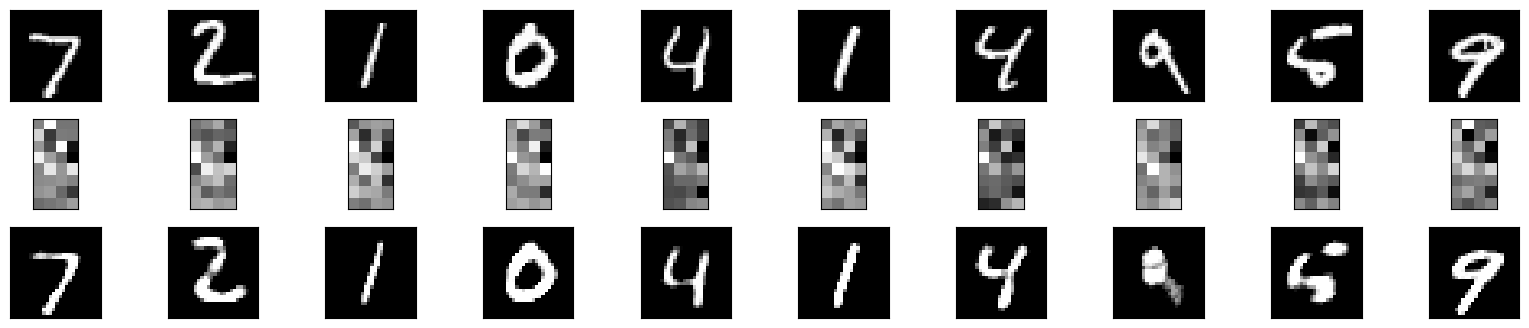

In [16]:
plot_reconstructions(model)

## 2. Optional

At this stage, you can code the interpolation described in the lesson to obtain:

![](https://raw.githubusercontent.com/dataflowr/slides/master/images/module9/interp_AE.png)

In [17]:
yy, labels = next(iter(test_loader))
labels

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [18]:
num2lab = dict([(int(j), i) for i, j in enumerate(labels)])

In [19]:
encoded2 = model.encoder(yy[num2lab[2]].reshape(1, -1))
encoded9 = model.encoder(yy[num2lab[9]].reshape(1, -1))

In [20]:
alphas = torch.linspace(0, 1, 10).reshape(-1, 1)
interp = alphas*encoded9 + (1-alphas)*encoded2
decoded_interp = model.decoder(interp)

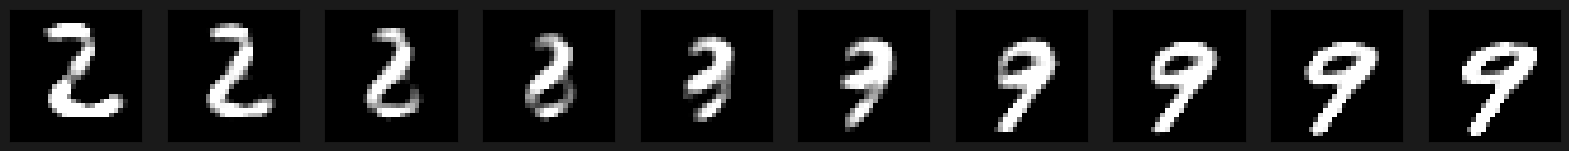

In [21]:
decoded_interp = to_img(decoded_interp)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    
    plt.imshow(decoded_interp[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.gcf().set_facecolor("#1A1A1A")
plt.show()

# cool

In [22]:
# compared with interpolation on data level

In [23]:
data2 = yy[num2lab[2]]
data9 = yy[num2lab[9]]

data2, data9 = data2.reshape(1, -1), data9.reshape(1, -1)

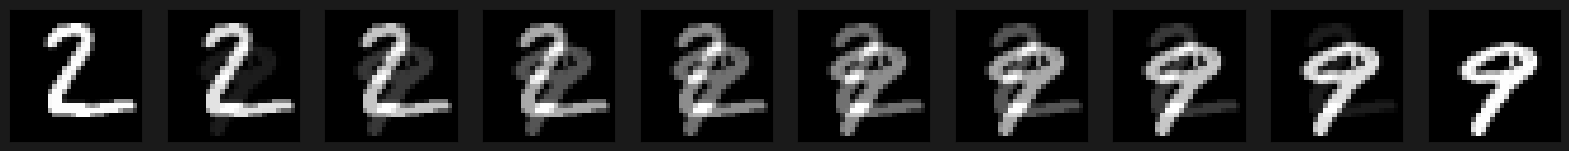

In [24]:
interp = alphas*data9 + (1-alphas)*data2
interp = to_img(interp)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    
    plt.imshow(interp[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.gcf().set_facecolor("#1A1A1A")
plt.show()

# lol, stupid

# 3. Exercise: Implement a denoising AE:


Use previous code and with minimal modifications, transform your AE in a denoising AE. Now, you first apply some noise to your input and try to recover the original data at the output. For the noise, you can add some random noise or erase some of the pixels. In this last case, you should obtain something like: 

![](https://raw.githubusercontent.com/dataflowr/slides/master/images/module9/denoising_AE.png)

The first line corresponds to the original digit, the second line to the noisy version of the digit given as input to your network, the third line is the associated code and the last line is the denoised digit obtained by your decoder from the code.

---
tests

In [25]:
torch.randint(0, 10, [2, 5])

tensor([[9, 0, 2, 0, 4],
        [4, 1, 8, 9, 2]])

In [26]:
t = torch.tensor([[1, 2], [2, 4]])
display(t)
t + t.max(1).values.reshape(-1, 1)

tensor([[1, 2],
        [2, 4]])

tensor([[3, 4],
        [6, 8]])

In [27]:
yy, _ = next(iter(train_loader))

In [28]:
yy.size()

torch.Size([256, 1, 28, 28])

In [29]:
yy.reshape(-1, 784).size()

torch.Size([256, 784])

In [30]:
yy = yy.reshape(-1, 784)

In [31]:
yy.min(1).values.size()

torch.Size([256])

In [32]:
data_test = (yy - yy.min(1).values.reshape(-1, 1)) / yy.max(1).values.reshape(-1, 1) * yy.max(1).values.reshape(-1, 1)

In [33]:
yy.max()

tensor(1.)

In [34]:
data_test.max()

tensor(1.)

In [80]:
# testing of min-max scaling to match to original data
yy, _ = next(iter(train_loader))
yy = yy.reshape(-1, 28**2)
noisy_data = yy + torch.randn(yy.size()) * .1
noisy_data = (noisy_data - noisy_data.min(1).values.reshape(-1, 1)) 
noisy_data = noisy_data/ noisy_data.max(1).values.reshape(-1, 1) * yy.max(1).values.reshape(-1, 1)
torch.all(noisy_data.max(1).values == yy.max(1).values)

tensor(True)

---

In [81]:
# You need first to modify the training process by adding noise to your data
# Hint if you want to erase pixels: https://stackoverflow.com/questions/49216615/is-there-an-efficient-way-to-create-a-random-bit-mask-in-pytorch
def train_denoiser(model,loss_fn, train_loader=None,epochs=1,optimizer=None, noise=0.8):
    model.train()
    for epoch in range(epochs):
      for batch_idx, (data, _) in enumerate(train_loader):
        #
        # your code here to create the noisy_data
        #
        data = data.reshape(-1, 28**2)
        noisy_data = data + torch.randn(data.size()) * noise
        noisy_data = (noisy_data - noisy_data.min(1).values.reshape(-1, 1)) 
        noisy_data = noisy_data/ noisy_data.max(1).values.reshape(-1, 1) * data.max(1).values.reshape(-1, 1)

        optimizer.zero_grad()
        output = model(noisy_data)
        loss = loss_fn(output, data)
        loss.backward()
        optimizer.step()
            
        # if batch_idx % 100 == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(data_loader.dataset),
        #         100. * batch_idx / len(data_loader), loss.data.item()))
      print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch, loss))

In [82]:
input_dim = 784
encoding_dim = 32

model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss()

In [86]:
train_denoiser(model, loss_fn,train_loader,epochs=20,optimizer=optimizer, noise=0.8)

Train Epoch: 0	Loss: 0.189766
Train Epoch: 1	Loss: 0.179811
Train Epoch: 2	Loss: 0.189728
Train Epoch: 3	Loss: 0.188004
Train Epoch: 4	Loss: 0.194680
Train Epoch: 5	Loss: 0.175142
Train Epoch: 6	Loss: 0.182421
Train Epoch: 7	Loss: 0.179095
Train Epoch: 8	Loss: 0.175924
Train Epoch: 9	Loss: 0.180181
Train Epoch: 10	Loss: 0.179121
Train Epoch: 11	Loss: 0.168211
Train Epoch: 12	Loss: 0.172197
Train Epoch: 13	Loss: 0.166449
Train Epoch: 14	Loss: 0.175690
Train Epoch: 15	Loss: 0.166333
Train Epoch: 16	Loss: 0.175918
Train Epoch: 17	Loss: 0.164814
Train Epoch: 18	Loss: 0.162916
Train Epoch: 19	Loss: 0.155027


In [87]:
# Now you need to modify the plot function
def plot_denoising(model, noise=0.8):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, , the second row is the noisy digits, 
    the third row is the encoded vector and
    the bottom is the decoder reconstruction.
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    #
    # your code here to compute
    # noisy_data
    # encoded_imgs
    # decoded_imgs
    #
    data = data.reshape(-1, 28**2)
    noisy_data = data + torch.randn(data.size()) * noise
    noisy_data = (noisy_data - noisy_data.min(1).values.reshape(-1, 1)) 
    noisy_data = noisy_data/ noisy_data.max(1).values.reshape(-1, 1) * data.max(1).values.reshape(-1, 1)
    
    encoded_imgs = model.encoder(noisy_data)
    decoded_imgs = model.decoder(encoded_imgs)
    
    
    true_imgs = to_img(data)
    noisy_imgs = to_img(noisy_data)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display corrupted original
        ax = plt.subplot(4, n, i + 1 +n)
        plt.imshow(noisy_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display code
        ax = plt.subplot(4, n, i + 1 + 2*n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(4, n, i + 1 +  3*n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

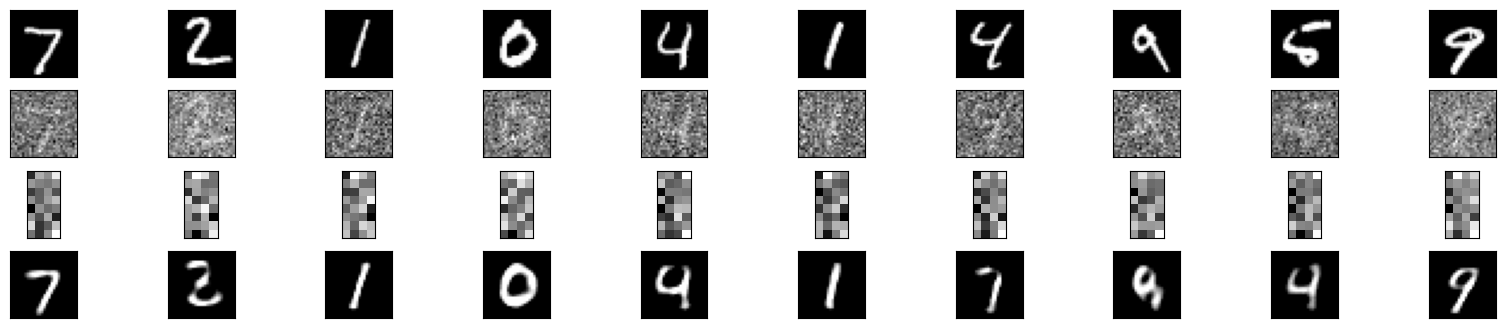

In [88]:
plot_denoising(model, noise=0.8)

# 4. Optional: how to deal with convolutions?

Hint: start by decreasing the size of your image with `Conv2d` by using a `stride` like:

In [117]:
conv = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride=2)
x = torch.randn(2, 1, 64, 64)
y = conv(x)
y.shape

torch.Size([2, 16, 32, 32])

Now use [transposed convolution](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) (or [deconvolution](https://distill.pub/2016/deconv-checkerboard/)) with the same parameters:

In [118]:
convt = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, padding=1, output_padding=1 ,stride=2)

In [119]:
convt(y).shape

torch.Size([2, 1, 64, 64])

To get the same size as `x`, play with `output_padding`.

Now, you have all the tools to build a convolutional autoencoder!

In [307]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        #
        # your code here
        #
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride=2),
            nn.ReLU(), 
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=2),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, padding=1, output_padding=1, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=4, padding=1, output_padding=2, stride=3),
        )
        
        # self.encoder = nn.Sequential( 
        #     nn.Conv2d(1, 64, 3, stride=2, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(64, 64, 3, stride=2, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(64, 32, 3)
        # )
        # self.decoder = nn.Sequential(
        #     nn.ConvTranspose2d(32, 64, 3, stride=3, padding=1, output_padding=1),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(64, 64, 3, stride=3, padding=1, output_padding=1),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1)
        # )
        
        
    def forward(self, x):
        #
        # your code here
        #
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

In [308]:
t = ConvAutoEncoder()
t(torch.randn((2, 1, 14, 14))).size()

torch.Size([2, 1, 28, 28])

In [309]:
def train_conv(model,loss_fn, train_loader=None,epochs=1,optimizer=None,noise=.8):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.reshape(-1, 28**2)
            noisy_data = data + torch.randn(data.size()) * noise
            noisy_data = (noisy_data - noisy_data.min(1).values.reshape(-1, 1)) 
            noisy_data = noisy_data / noisy_data.max(1).values.reshape(-1, 1) * data.max(1).values.reshape(-1, 1)

            data = data.reshape(-1, 1, 28, 28)
            noisy_data = noisy_data.reshape(-1, 1, 28, 28)
            noisy_data_reduzsed = F.avg_pool2d(noisy_data, kernel_size=2)
            optimizer.zero_grad()
            output = model(noisy_data_reduzsed)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()

        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch, loss))

In [ ]:
model = ConvAutoEncoder()
optimizer = optim.Adam(model.parameters())

In [315]:
train_conv(model, loss_fn,train_loader,epochs=10,optimizer=optimizer)

Train Epoch: 0	Loss: 0.199329
Train Epoch: 1	Loss: 0.194263
Train Epoch: 2	Loss: 0.195699
Train Epoch: 3	Loss: 0.191967
Train Epoch: 4	Loss: 0.186392
Train Epoch: 5	Loss: 0.185521
Train Epoch: 6	Loss: 0.183759
Train Epoch: 7	Loss: 0.186336
Train Epoch: 8	Loss: 0.184195
Train Epoch: 9	Loss: 0.187054


In [316]:
import pickle
file = open("model_conv.sav",'wb')
pickle.dump(model, file)

In [317]:
def to_img(x, size=28):
    x = x.cpu().data.numpy()
    x = 0.5 * (x + 1)
    x = np.clip(x, 0, 1)
    x = x.reshape([-1, size, size])
    return x

def plot_conv_denoising(model, noise=.8):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    The middle row is the encoded vector.
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    
    data = data.reshape(-1, 28**2)
    noisy_data = data + torch.randn(data.size()) * noise
    noisy_data = (noisy_data - noisy_data.min(1).values.reshape(-1, 1)) 
    noisy_data = noisy_data / noisy_data.max(1).values.reshape(-1, 1) * data.max(1).values.reshape(-1, 1)

    data = data.reshape(-1, 1, 28, 28)
    noisy_data = noisy_data.reshape(-1, 1, 28, 28)
            
    noisy_data_redused = F.avg_pool2d(noisy_data, kernel_size = 2)
    #data += noise * torch.randn(data.size())
    data = data.to(device)
    noisy_data_redused = noisy_data_redused.to(device)
    
    noisy_data_redused.requires_grad = False
    encoded_imgs = model.encoder(noisy_data_redused)
    decoded_imgs = model.decoder(encoded_imgs)
    
    true_imgs = to_img(data)
    noisy_imgs = to_img(noisy_data)
    noisy_redused_imgs = to_img(noisy_data_redused, size=14)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()
    
    n = 10
    plt.figure(figsize=(25, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(5, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display corrupted original
        ax = plt.subplot(5, n, i + 1 +n)
        plt.imshow(noisy_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display corrupted original
        ax = plt.subplot(5, n, i + 1 +2*n)
        plt.imshow(noisy_redused_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(5, n, i + 1 + 3*n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(5, n, i + 1 + 4*n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

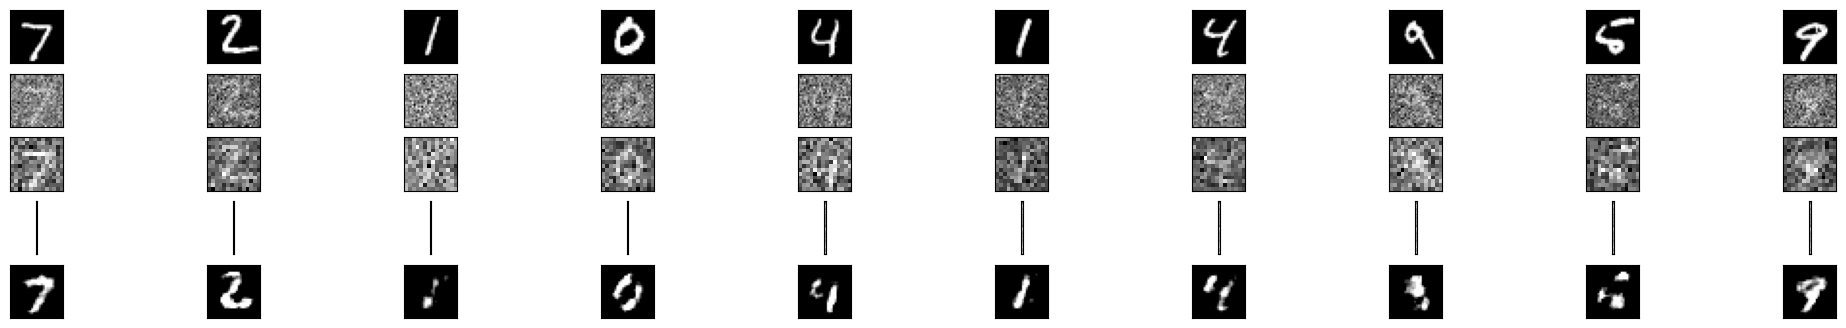

In [318]:
plot_conv_denoising(model)

[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)